# Transformers - Speech commands classification with Transformers

## Code/Data-Preparation

In [57]:
# Install dependencies
! pip install librosa
! pip install numpy
! pip install matplotlib
! pip install seaborn
! pip install scikit-learn
! pip install scipy

! pip install tensorflow --upgrade
! pip install keras --upgrade

   ---------------------------------------- 0.0/15.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.7 MB 656.4 kB/s eta 0:00:24
    --------------------------------------- 0.2/15.7 MB 1.6 MB/s eta 0:00:10
   - -------------------------------------- 0.5/15.7 MB 3.1 MB/s eta 0:00:05
   -- ------------------------------------- 1.1/15.7 MB 5.3 MB/s eta 0:00:03
   ----- ---------------------------------- 2.1/15.7 MB 8.4 MB/s eta 0:00:02
   ------- -------------------------------- 3.0/15.7 MB 10.0 MB/s eta 0:00:02
   -------- ------------------------------- 3.4/15.7 MB 10.5 MB/s eta 0:00:02
   ---------- ----------------------------- 4.1/15.7 MB 10.5 MB/s eta 0:00:02
   ----------- ---------------------------- 4.4/15.7 MB 10.0 MB/s eta 0:00:02
   ---------------- ----------------------- 6.6/15.7 MB 13.6 MB/s eta 0:00:01
   --------------------- ------------------ 8.4/15.7 MB 15.7 MB/s eta 0:00:01
   --

In [5]:
# Please read the guidelines on https://www.kaggle.com/docs/api#authentication
# to get an idea where to put your kaggle API token to be able to download the dataset

! pip install kaggle
! kaggle competitions download -c "tensorflow-speech-recognition-challenge"

! tar -xf tensorflow-speech-recognition-challenge.zip -C ../data/challenge
! del tensorflow-speech-recognition-challenge.zip

# To extract the dataset, we need to have 7-zip (https://www.7-zip.org/) installed and added to our $PATH
! 7z x -o..\data\challenge ..\data\challenge\test.7z
! 7z x -o..\data\challenge ..\data\challenge\train.7z



  0%|          | 0.00/3.50G [00:00<?, ?B/s]
  0%|          | 1.00M/3.50G [00:00<39:21, 1.59MB/s]
  0%|          | 2.00M/3.50G [00:00<20:06, 3.12MB/s]
  0%|          | 4.00M/3.50G [00:00<09:25, 6.65MB/s]
  0%|          | 6.00M/3.50G [00:00<06:31, 9.60MB/s]
  0%|          | 8.00M/3.50G [00:01<05:35, 11.2MB/s]
  0%|          | 10.0M/3.50G [00:01<05:00, 12.5MB/s]
  0%|          | 12.0M/3.50G [00:01<04:38, 13.5MB/s]
  0%|          | 14.0M/3.50G [00:01<04:25, 14.1MB/s]
  0%|          | 16.0M/3.50G [00:01<04:18, 14.5MB/s]
  1%|          | 18.0M/3.50G [00:01<04:00, 15.5MB/s]
  1%|          | 21.0M/3.50G [00:01<03:35, 17.3MB/s]
  1%|          | 23.0M/3.50G [00:02<03:30, 17.7MB/s]
  1%|          | 25.0M/3.50G [00:02<03:28, 17.9MB/s]
  1%|          | 27.0M/3.50G [00:02<03:28, 17.9MB/s]
  1%|          | 29.0M/3.50G [00:02<03:30, 17.8MB/s]
  1%|          | 31.0M/3.50G [00:02<03:35, 17.3MB/s]
  1%|          | 34.0M/3.50G [00:02<03:13, 19.3MB/s]
  1%|          | 36.0M/3.50G [00:02<03:22, 18.4MB/s]
 


7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive for archives:
1 file, 2640679130 bytes (2519 MiB)

Extracting archive: ..\data\challenge\test.7z
--
Path = ..\data\challenge\test.7z
Type = 7z
Physical Size = 2640679130
Headers Size = 1345163
Method = Delta LZMA2:24
Solid = +
Blocks = 3

Everything is Ok

Folders: 2
Files: 158538
Size:       5080191672
Compressed: 2640679130

7-Zip 23.01 (x64) : Copyright (c) 1999-2023 Igor Pavlov : 2023-06-20

Scanning the drive for archives:
1 file, 1121103842 bytes (1070 MiB)

Extracting archive: ..\data\challenge\train.7z
--
Path = ..\data\challenge\train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

Everything is Ok

Folders: 33
Files: 64732
Size:       2055161498
Compressed: 1121103842


In [60]:
# Imports
from pathlib import Path
from scipy.io import wavfile
from scipy import signal
import librosa

import numpy as np

import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Loading

In [15]:
train_path = Path(Path('.').resolve().parent, "data/challenge/train/audio/")

### Visualisation
To check if data is of the expected format, we visualise characteristics some example file. The code for this part is adapted from https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration

In [62]:
# Define and open file to visualise
file_to_visualise = "yes/0a7c2a8d_nohash_0.wav"
filepath = Path(train_path, file_to_visualise)
sample_rate, data = wavfile.read(filepath)

### Wave and spectrogram

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.


(From https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=5)


In [28]:
# Define a function that calculates spectrogram. (https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=6)
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

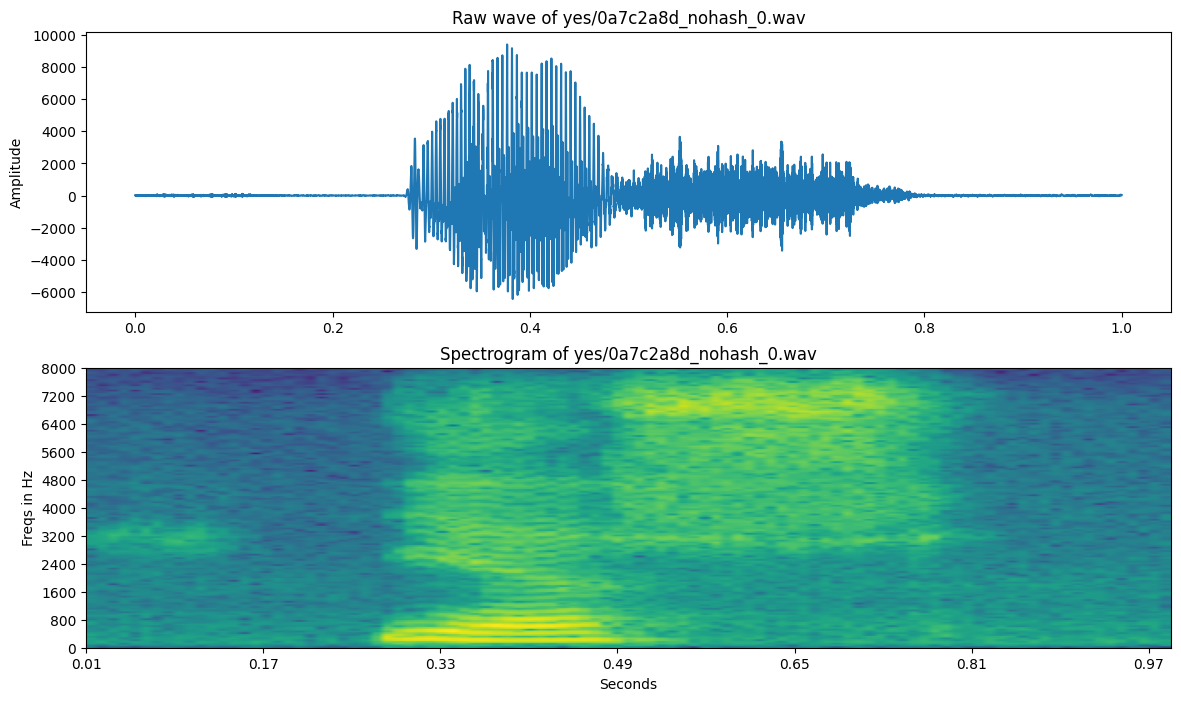

In [46]:
freqs, times, spectrogram = log_specgram(data, sample_rate)

def plot_wave_spectrogram(data, sample_rate):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + file_to_visualise)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(data), sample_rate), data)

    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
            extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + file_to_visualise)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')

plot_wave_spectrogram(data, sample_rate)

In [47]:
# Normalise spectrogram to be suitable as input for neuronal network
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=10
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

### Mel Frequency Cepstral Coefficient (MFCC)
MFCCs are used in speach recognition approaches.  They are a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. (https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

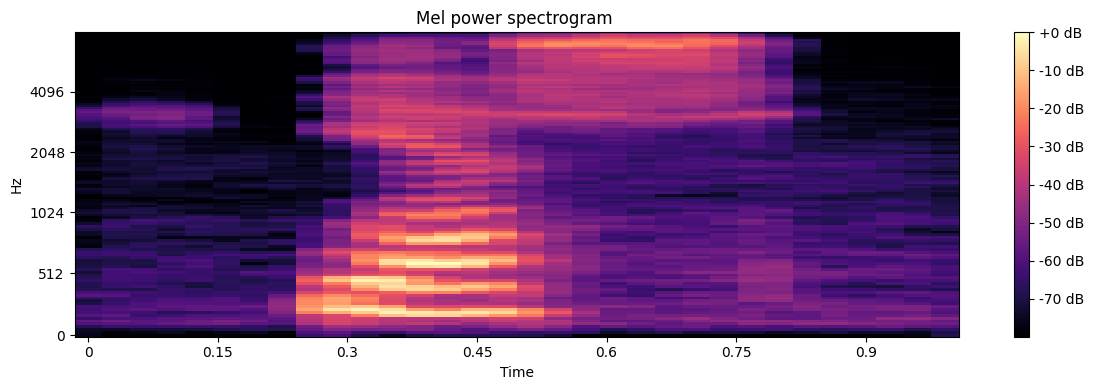

In [55]:
# Calculate the Mel power spectrogram

# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=13
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(y=data.astype(np.float32), sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

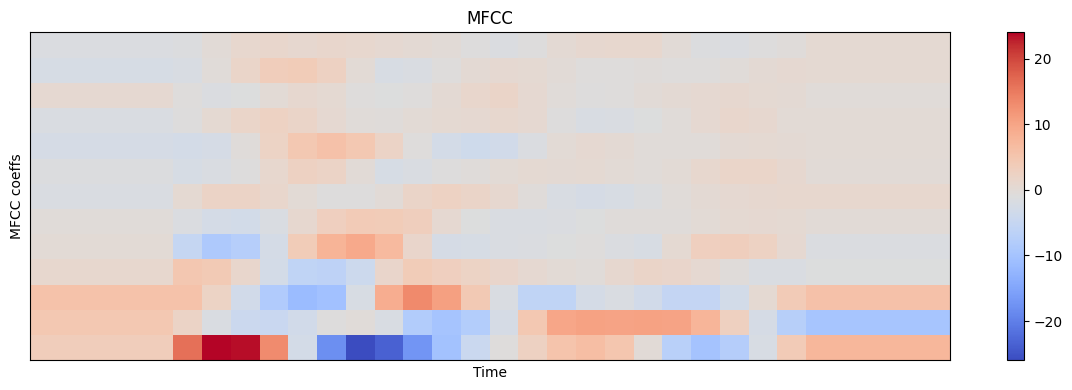

In [56]:
# Calculate MFCC
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=14

mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, MFCC or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example MFCC decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.

From: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=15

### Detect silence
Despite our audio samples are only 1 second long, they still include some silence. Removing that silence would decrease our training size. We should use VAD (Voice Activity Detection) for that, but that is not a priority for now and more a proposal for future work.

In [63]:
# Example audio
ipd.Audio(data=data, rate=sample_rate)

In [65]:
# Cut audio 
data_cut = data[4000:13000]
ipd.Audio(data_cut, rate=sample_rate)
# Still entire word can be heard, but audio is 7000 samples shorter

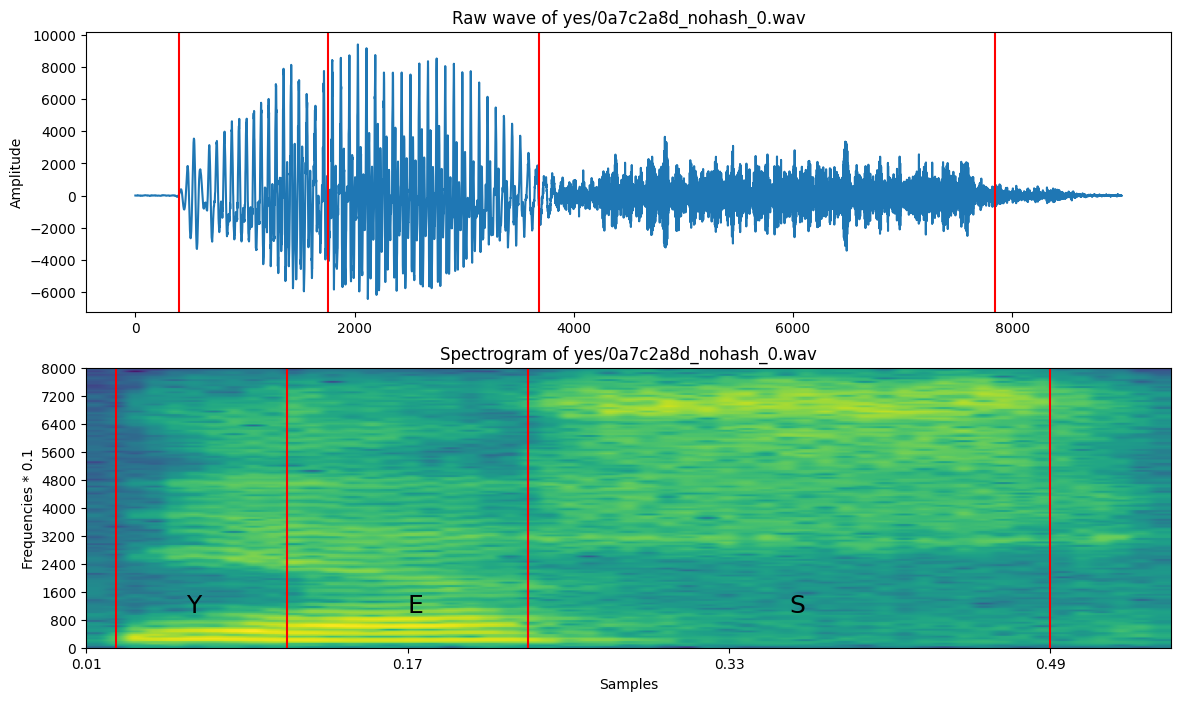

In [68]:
# Visualise silence cut
# https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration?scriptVersionId=1924001&cellId=24
freqs, times, spectrogram_cut = log_specgram(data_cut, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + file_to_visualise)
ax1.set_ylabel('Amplitude')
ax1.plot(data_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + file_to_visualise)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

## CNN
We train a CNN to classify the speech data